# Model Comparison and Dreams
*Sean Steinle, Kiya Aminfar*

This notebook analyzes the results of our best models, comparing them against a random policy and a PPO policy. Additionally, we try to reconstruct 'dreams' from the latent space, `z`.

## Table of Contents
1. [Model Comparison](#Model-Comparison)
2. [Rendering Dreams](#Rendering-Dreams)

## Model Comparison

In this section, we compare our best model against a random policy and a PPO policy.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2025-05-11 12:21:48.102707: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 12:21:48.145745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746980508.196538    6966 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746980508.213284    6966 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746980508.239894    6966 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
#a slightly updated version of play_agent()
def play_agent(env_name, model=None, n_timesteps=50, render_mode=None):
    """Plays games using a provided model or random policy."""
    env = gym.make(env_name, render_mode='rgb_array' if render_mode == None else render_mode)
    obs, info = env.reset()
    rewards = []
    episode_lengths = []
    steps = 0

    while steps < n_timesteps:
        if render_mode: env.render()
        if model is None: #random policy
            action = env.action_space.sample()
        elif hasattr(model, "predict"): #SB3 models use 'predict'
            action, _ = model.predict(obs)
        else: #our model uses `model(obs)`
            action = model(obs)  # assumes model is a callable function

        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        steps += 1

        if terminated or truncated:
            episode_lengths.append(steps)
            obs, info = env.reset()

    env.close()
    return rewards, episode_lengths

In [3]:
n_timesteps = 1000

In [4]:
#running the random policy
random_rewards, random_lengths = play_agent(env_name="Humanoid-v5", model=None, n_timesteps=n_timesteps, render_mode=None)
np.sum(random_rewards), np.mean(random_lengths) #avg reward, avg episode length of random policy

(np.float64(4709.147111154784), np.float64(488.95))

In [5]:
#running the PPO policy
from stable_baselines3 import PPO
ppo_policy = PPO.load(f"../models/basic/humanoid_500000.zip")
ppo_rewards, ppo_lengths = play_agent(env_name="Humanoid-v5", model=ppo_policy, n_timesteps=n_timesteps, render_mode=None)
np.sum(ppo_rewards), np.mean(ppo_lengths) #avg reward, avg episode length of random policy

(np.float64(4785.276998932606), np.float64(546.5))

In [6]:
#running the world model policy

#import core model architectures and wrapper
from utils import MLPVAE, MDNRNN, LinearController, make_world_model_policy

#parameters
vae_path = '../models/vae/vae_250000.weights.h5'
mdnrnn_path = '../models/mdnrnn/mdnrnn_250000_25.weights.h5'
controller_path = '../models/controller/controller_250000_25_100.weights.h5'
O_DIM = 348
Z_DIM = 32
A_DIM = 17
SEQ_LEN = 10

#load VAE
vae = MLPVAE(input_dim=O_DIM, z_size=Z_DIM) #instantiate new model object 
vae(tf.zeros((1, O_DIM))) #invoke it to build its shape 
vae.load_weights(vae_path) #now load weights into empty vector

#load MDNRNN
mdnrnn = mdnrnn = MDNRNN(latent_dim=Z_DIM, action_dim=A_DIM) #instantiate new model object 
mdnrnn(tf.zeros((1, SEQ_LEN, Z_DIM+A_DIM))) #invoke it to build its shape 
mdnrnn.load_weights(mdnrnn_path) #now load weights into empty vector

#load controller
controller = LinearController(input_dim=288, action_dim=A_DIM)
controller.build((1,288))
controller.load_weights(controller_path)

#put it all together and run!
wm_policy = make_world_model_policy(vae, mdnrnn, controller)
wm_rewards, wm_lengths = play_agent(env_name="Humanoid-v5", model=wm_policy, n_timesteps=n_timesteps, render_mode=None)
np.sum(wm_rewards), np.mean(wm_lengths) #avg reward, avg episode length of world model policy

/home/seansteinle/.pyenv/versions/cs757-final-project/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-05-11 12:22:00.637946: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(np.float64(3581.457667728283), np.float64(513.8888888888889))

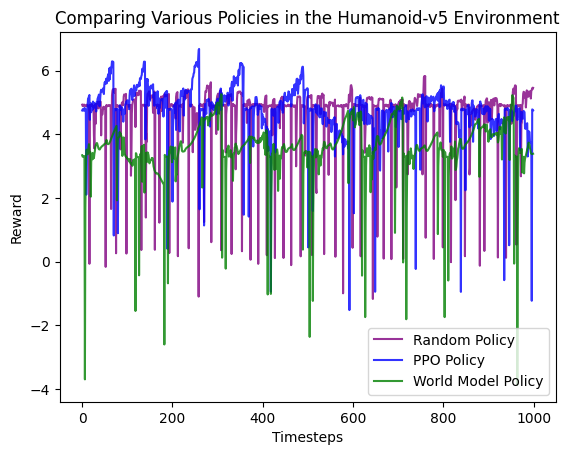

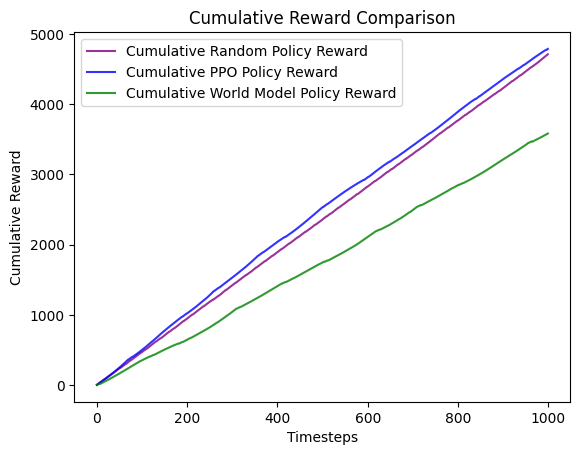

Average Reward (Random Policy): 4.71 ± 1.06
Average Reward (PPO Policy): 4.79 ± 0.84
Average Reward (World Model Policy): 3.58 ± 0.90


In [23]:
#compare random and trained policy results visually!
plt.plot(range(n_timesteps), random_rewards, color='purple', label='Random Policy', alpha=0.8)
plt.plot(range(n_timesteps), ppo_rewards, color='blue', label='PPO Policy', alpha=0.8)
plt.plot(range(n_timesteps), wm_rewards, color='green', label='World Model Policy', alpha=0.8)
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Sequential Rewards of Policies in the Humanoid-v5 Environment")
plt.legend()
plt.savefig("../doc/plots/sequential_rewards.png")
plt.show()

cumulative_random = np.cumsum(random_rewards)
cumulative_ppo = np.cumsum(ppo_rewards)
cumulative_wm = np.cumsum(wm_rewards)

plt.plot(range(n_timesteps), cumulative_random, color='purple', label='Cumulative Random Policy Reward', alpha=0.8)
plt.plot(range(n_timesteps), cumulative_ppo, color='blue', label='Cumulative PPO Policy Reward', alpha=0.8)
plt.plot(range(n_timesteps), cumulative_wm, color='green', label='Cumulative World Model Policy Reward', alpha=0.8)
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards of Policies in the Humanoid-v5 Environment")
plt.legend()
plt.savefig("../doc/plots/cumulative_rewards.png")
plt.show()

print(f"Average Reward (Random Policy): {np.mean(random_rewards):.2f} ± {np.std(random_rewards):.2f}")
print(f"Average Reward (PPO Policy): {np.mean(ppo_rewards):.2f} ± {np.std(ppo_rewards):.2f}")
print(f"Average Reward (World Model Policy): {np.mean(wm_rewards):.2f} ± {np.std(wm_rewards):.2f}")

## Rendering Dreams

In this section we're going to try to render a reconstructed observation space as the actual gymnasium environment! This is nontrivial since `env.render()` does not actually take observations as an argument. Thus, we either need to interact directly with a MuJoCo simulation or figure another way around!

In [8]:
o = np.load('../data/processed/Humanoid-v5_10000/observations.npy')

In [9]:
#here are our raw observations
o[0]

array([ 1.39437816e+00,  9.99968250e-01,  3.79864485e-03,  6.59385841e-03,
       -2.36428642e-03, -6.44013275e-03,  4.04482542e-02, -1.73932945e-02,
        7.02069696e-03, -1.64809519e-02, -5.87085982e-02, -8.31239564e-02,
       -2.32992584e-02,  5.96162997e-02, -3.89616689e-02,  2.65256705e-03,
       -8.19216933e-03, -1.37551596e-02,  1.69978972e-02, -4.73424357e-03,
       -5.79563778e-03,  2.03695153e-02,  2.00603784e-01,  4.37858659e-02,
       -2.19800178e-01,  1.58938603e-01,  4.42704435e-02,  1.07000006e+00,
       -1.31639174e+00,  2.79643428e+00, -1.52624409e+00,  1.82807029e+00,
       -2.23633396e+00, -7.54125526e+00, -1.01836506e+01, -1.99326228e+00,
        5.13092967e+00, -4.59377304e+00, -5.50918487e-01, -1.96932012e+00,
       -1.40859456e+00,  2.99984654e+00, -1.34652410e-01, -1.24951469e+00,
        1.88820864e+00,  2.30075750e+00,  2.28182635e+00,  4.14710432e-02,
       -9.92898973e-05,  1.05918959e-02,  7.30889934e-03, -3.23869504e-02,
       -1.31595755e-02,  

In [10]:
o_mu, o_sigma = np.mean(o, axis=0), np.std(o, axis=0) #get mean and std of original observations
o_standardized = (o - o_mu) / (o_sigma + 1e-6) #standardize observations
mu, logvar = vae.encode(o_standardized) #get mean and std of each dimension of z
z = vae.sample_z(mu, logvar) #sample actual z values
reconstr_norm_o = vae.decode(z) #decode z values into standardized obs
o_r = reconstr_norm_o * (o_sigma + 1e-6) + o_mu #backtransform into original obs space with mean and std of original observations
o_r = o_r.numpy()
o_r #o_reconstructed is a sample from our VAE around the original observation space!

array([[ 1.3967378 ,  1.0007004 ,  0.01217751, ...,  0.16404124,
        -0.0289869 , -0.5952835 ],
       [ 1.3736073 ,  0.99783033, -0.00458895, ..., -0.09835809,
         0.2963593 , -0.11887458],
       [ 1.3922433 ,  0.99696517,  0.01882839, ..., -0.01530591,
         0.18126115, -0.49317965],
       ...,
       [ 1.3682563 ,  0.9936153 ,  0.01290173, ...,  0.15132013,
         0.05862838, -0.2354207 ],
       [ 1.3358413 ,  0.99540377,  0.02383117, ...,  0.30990657,
        -0.02306345,  0.19345853],
       [ 1.3092834 ,  0.99695975,  0.01240155, ...,  0.1601595 ,
        -0.47273204,  0.00158852]], dtype=float32)

In [11]:
o_error = o - o_r
o_error[0][:10]
#there is definitely a decent amount of error on the reconstructions... this will certaintly impact our model

array([-0.00235965, -0.0007321 , -0.00837886,  0.00628981, -0.02835198,
       -0.02184586,  0.00372297,  0.01941987,  0.003934  , -0.01322709])

In [12]:
qpos = o[0][0:24] #these are POSITIONS
qpos

array([ 1.39437816,  0.99996825,  0.00379864,  0.00659386, -0.00236429,
       -0.00644013,  0.04044825, -0.01739329,  0.0070207 , -0.01648095,
       -0.0587086 , -0.08312396, -0.02329926,  0.0596163 , -0.03896167,
        0.00265257, -0.00819217, -0.01375516,  0.0169979 , -0.00473424,
       -0.00579564,  0.02036952,  0.20060378,  0.04378587])

In [13]:
qvel = o[0][24:47]
qvel

array([ -0.21980018,   0.1589386 ,   0.04427044,   1.07000006,
        -1.31639174,   2.79643428,  -1.52624409,   1.82807029,
        -2.23633396,  -7.54125526, -10.18365056,  -1.99326228,
         5.13092967,  -4.59377304,  -0.55091849,  -1.96932012,
        -1.40859456,   2.99984654,  -0.13465241,  -1.24951469,
         1.88820864,   2.3007575 ,   2.28182635])

The key challenge: rendering in MuJoCo is more than hard-setting the observations. The actual *state* is a black-box function that transforms observations in a bunch of confusing ways. Thus, we can try to run a simulation with a hard-set observations, but even for true observations this will look clunky. Thus, let's capture a video of the true state playing, the true observations playing, and our observations playing.

In [14]:
import imageio

def gather_states(n_steps: int):
    qpos_qvel = []
    env = gym.make('Humanoid-v5', render_mode="rgb_array")
    env.reset()

    for _ in range(n_steps):
        qpos = env.unwrapped.data.qpos.copy()
        qvel = env.unwrapped.data.qvel.copy()
        qpos_qvel.append(np.concatenate([qpos, qvel]))
        env.step(env.action_space.sample())

    env.close()
    return np.array(qpos_qvel)

def play_from_states(states: np.array, out_path: str):
    env = gym.make('Humanoid-v5', render_mode="rgb_array")
    env.reset()

    frames = []
    for i in range(states.shape[0]):
        qpos = states[i][:env.unwrapped.model.nq]
        qvel = states[i][env.unwrapped.model.nq:]
        env.unwrapped.set_state(qpos, qvel)
        frame = env.render()
        frames.append(frame)
    
    env.close()
    imageio.mimsave(out_path, frames, fps=30)

In [15]:
def play_from_obs(o: np.array, out_path: str):
    env = gym.make('Humanoid-v5', render_mode="rgb_array")
    _, _ = env.reset()

    frames = []
    for i in range(o.shape[0]):
        qpos = o[i][:24]      # 22-dimensional (0-21 inclusive)
        qvel = o[i][24:47]    # 23-dimensional (22-44 inclusive)
        env.unwrapped.set_state(qpos, qvel)
        frame = env.render()
        frames.append(frame)

    env.close()
    imageio.mimsave(out_path, frames, fps=30)

In [19]:
#states video -- looks good!
states = gather_states(200)
play_from_states(states, "../doc/videos/true_state.mp4") #this takes a minute or two

In [20]:
#true observations video -- oh boy
play_from_obs(o[:200], "../doc/videos/true_obs.mp4")  #this takes a minute or two

In [21]:
#similar ish to true observations! good sign ?
play_from_obs(o_r[:200], "../doc/videos/reconstr_obs.mp4") #this takes a minute or two